In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from Kraken API

In [3]:
import krakenex
k = krakenex.API()
res = k.query_public('OHLC', {'pair': 'XETHZEUR', 'interval': 1})

In [6]:
data = res['result']['XETHZEUR']

In [5]:
nb_data = len(data)
open_values = np.array([data[i][1] for i in range(nb_data)], dtype=float)
closing_values = np.array([data[i][4] for i in range(nb_data)], dtype=float)
lowest_values = np.array([data[i][3] for i in range(nb_data)], dtype=float)
highest_values = np.array([data[i][2] for i in range(nb_data)], dtype=float)
av_values = np.array([data[i][5] for i in range(nb_data)], dtype=float)
data_bin = np.array([(closing_values[i] - open_values[i] > 0.) for i in range(nb_data)], dtype=int)

# Transactions BTC-EUR from 01/08/2014

In [7]:
btc_eur = np.loadtxt('krakenEUR.csv', delimiter=',')

In [9]:
# time stamp, price, volume
nb_data = btc_eur.shape[0]
time, price, volume = btc_eur[:,0], btc_eur[:,1], btc_eur[:,2]
btc_eur[1:10,:]

array([[  1.38917320e+09,   6.24010000e+02,   9.76700000e-02],
       [  1.38917320e+09,   6.23538360e+02,   1.35797600e-02],
       [  1.38917326e+09,   6.23538360e+02,   1.48960240e-01],
       [  1.38917334e+09,   6.23540660e+02,   2.00000000e-01],
       [  1.38917353e+09,   6.23540660e+02,   1.76300000e-01],
       [  1.38917353e+09,   6.23540650e+02,   4.06330000e-01],
       [  1.38917354e+09,   6.23538460e+02,   2.00000000e-01],
       [  1.38917354e+09,   6.23538360e+02,   1.80000000e+00],
       [  1.38917367e+09,   6.23543260e+02,   3.76300000e-01]])

In [10]:
#vwap over time interval t
delta_t = 180
init_ind = 999 * (nb_data / 1000)
initial_time, final_time = time[init_ind], time[nb_data-1]
time_interval = final_time - initial_time
nb_bins = int(time_interval // delta_t +1)
vwap = np.zeros(nb_bins)
weights = np.zeros(nb_bins)
for j in range(init_ind, nb_data):
    ind = int((time[j]-initial_time)//delta_t)
    vwap[ind] += volume[j] * price[j]
    weights[ind] += volume[j]
for k in range(len(vwap)):
    if weights[k] > 0.0001:
        vwap[k] = vwap[k] / weights[k]
    else:
        vwap[k] = vwap[k-1]

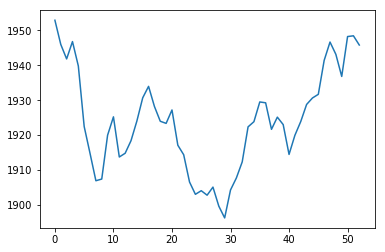

In [11]:
plt.plot(range(nb_bins), vwap)
plt.show()

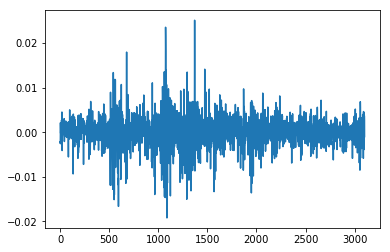

In [100]:
#log returns
y = np.log(vwap[1:]) - np.log(vwap[:nb_bins-1])
plt.plot(y)
plt.show()
#log returns squared
y2 = np.square(y) 

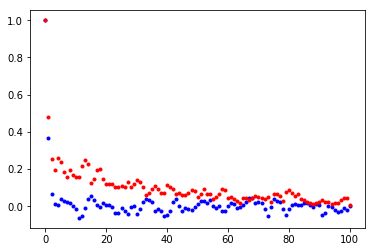

In [94]:
# ACF of log returns
from statsmodels.tsa.stattools import *
acf_y = acf(y, nlags=100)
acf_y2 = acf(y2, nlags=100)
plt.plot(acf_y, 'b .')
plt.plot(acf_y2, 'r .')
plt.show()

In [102]:
print np.min(y)
print np.max(y)
print np.mean(y)
print np.std(y)
from scipy.stats import skew, kurtosis
print skew(y)
print kurtosis(y)
from statsmodels.stats.diagnostic import acorr_ljungbox
res_arch = acorr_ljungbox(y)

-0.0192403801884
0.0251329849957
-2.5459478e-05
0.00333913946861
0.0590218262644
6.19165484


In [85]:
import datetime as dt
from arch import arch_model
am = arch_model(100*y, vol='GARCH', p=10, q=10, dist='StudentsT')
res = am.fit(disp='on')
print(res.summary())

Iteration:      1,   Func. Count:     25,   Neg. LLF: 333.793211881
Iteration:      2,   Func. Count:     59,   Neg. LLF: 325.561402179
Iteration:      3,   Func. Count:     85,   Neg. LLF: 258.332749585
Iteration:      4,   Func. Count:    113,   Neg. LLF: 258.090475733
Iteration:      5,   Func. Count:    139,   Neg. LLF: 230.144396617
Iteration:      6,   Func. Count:    165,   Neg. LLF: 225.930089938
Iteration:      7,   Func. Count:    192,   Neg. LLF: 225.13771847
Iteration:      8,   Func. Count:    218,   Neg. LLF: 212.490863038
Iteration:      9,   Func. Count:    244,   Neg. LLF: 210.439253584
Iteration:     10,   Func. Count:    270,   Neg. LLF: 207.82341436
Iteration:     11,   Func. Count:    296,   Neg. LLF: 205.314368694
Iteration:     12,   Func. Count:    322,   Neg. LLF: 204.831297468
Iteration:     13,   Func. Count:    348,   Neg. LLF: 204.154713197
Iteration:     14,   Func. Count:    374,   Neg. LLF: 203.543377865
Iteration:     15,   Func. Count:    400,   Neg. L

In [86]:
forecasts = res.forecast(horizon=5)
print forecasts.variance.dropna().head()
print forecasts.mean.dropna().head()
print forecasts.residual_variance.dropna().head()

           h.1       h.2       h.3       h.4       h.5
3101  0.071717  0.078218  0.088962  0.088464  0.095373
           h.1       h.2       h.3       h.4       h.5
3101  0.019547  0.019547  0.019547  0.019547  0.019547
           h.1       h.2       h.3       h.4       h.5
3101  0.071717  0.078218  0.088962  0.088464  0.095373
